<a href="https://colab.research.google.com/github/YKG-123/Fantasy_football_ML_Random_forest_Regressor/blob/main/TE_Prev_Season_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, spearmanr
import kagglehub
from kagglehub import KaggleDatasetAdapter
from google.colab import drive


In [3]:
file_path = "weekly_player_stats_offense.csv"
file_path2 = "yearly_player_stats_offense.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)
df2=kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path2,
)
import requests

years = range(2016, 2024)
all_adp = []

for y in years:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

adp_all = pd.concat(all_adp, ignore_index=True)

adp_all["name"] = adp_all["name"].str.strip()

print(adp_all.head())



adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)


adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",
        }))

df["player_name_merge"] = (
    df["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

df= df.merge(adp_all, on=["season", "player_name_merge"], how="left")

print(df[["player_name", "season", "adp", "position", "team"]].head())

/tmp/ipython-input-464360808.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 101M/101M [00:06<00:00, 16.5MB/s] 
/tmp/ipython-input-464360808.py:9: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df2=kagglehub.load_dataset(


Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
2016 — 188 players loaded
2017 — 184 players loaded
2018 — 197 players loaded
2019 — 200 players loaded
2020 — 203 players loaded
2021 — 211 players loaded
2022 — 157 players loaded
2023 — 202 players loaded
   player_id               name position team  adp adp_formatted  \
0       1886      Antonio Brown       WR  PIT  1.2          1.01   
1       1796        Julio Jones       WR  ATL  2.8          1.03   
2       2113  Odell Beckham Jr.       WR  NYG  3.4          1.03   
3       2297      David Johnson       RB  ARI  3.4          1.03   
4       2280        Todd Gurley       RB  LAR  6.3          1.06   

   times_drafted  high  low  stdev  bye  season  
0            454     1    4    0.5    5    2016  
1            348     1    6    0.9    5    2016  
2            512     1   10    1.2   14    2016  
3            146     1    7    1.5    8    2016  
4            470     1   12    1.8    8    2016  
     play

In [4]:
df=df[df["season"]>=2016]
df=df[df["season"]<=2022]
print(df["adp"])
df2=df2[df2["season"]>=2016]
df2=df2[df2["season"]<=2022]
df2=df2[df2["position"]=="TE"]
print(len(df2))
print(df2["season_average_fantasy_points_ppr"].describe())
df2=df2[df2["season_average_fantasy_points_ppr"]>=4.2]
print(len(df2))
print(df2[["player_name","season","season_average_fantasy_points_ppr"]]
          .sort_values("season_average_fantasy_points_ppr",ascending=False))

15557    68.5
15558    68.5
15559    68.5
15560    68.5
15561    68.5
         ... 
48545     NaN
48546     NaN
48547     NaN
48548     NaN
48549     NaN
Name: adp, Length: 32993, dtype: float64
855
count    855.000000
mean       5.295205
std        3.998779
min       -2.000000
25%        2.395000
50%        4.300000
75%        7.310000
max       27.670000
Name: season_average_fantasy_points_ppr, dtype: float64
441
            player_name  season  season_average_fantasy_points_ppr
4140       Travis Kelce    2020                              27.67
5368       Travis Kelce    2022                              25.57
4767       Travis Kelce    2021                              24.55
1853         Jared Cook    2016                              21.55
3539       Travis Kelce    2019                              21.30
...                 ...     ...                                ...
5899     Connor Heyward    2022                               4.22
2046  Crockett Gillmore    2016              

In [5]:
print(df2["season_average_fantasy_points_ppr"].describe())


count    441.000000
mean       8.146032
std        3.578006
min        4.200000
25%        5.490000
50%        7.150000
75%        9.980000
max       27.670000
Name: season_average_fantasy_points_ppr, dtype: float64


In [6]:

df = df[df['position'] == 'TE'].copy()
df=df[df["season_average_fantasy_points_ppr"]>=4.2]
df['week'] = df['week'].astype(int)
df['season'] = df['season'].astype(int)
df["adp"]=df["adp"].replace(0,200)


485
Train R²: 0.369
Test R²: 0.386


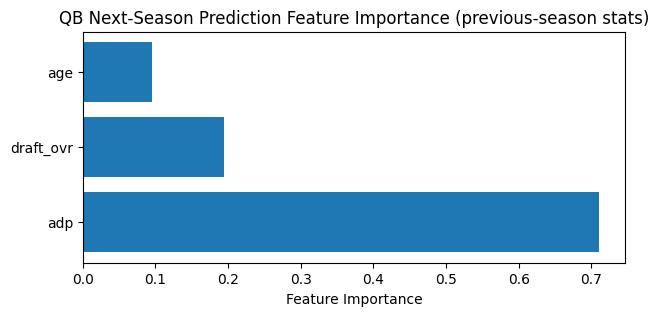

In [7]:
df_young=df
features = [                "adp","draft_ovr","age"

]
df_young=df_young.groupby(["player_name", "season"]).agg({
    "adp": "first",
    "draft_ovr": "first",
    "fantasy_points_ppr": "mean",
    "age":"first"
})
print(len(df_young))
X = df_young[features]

y = df_young["fantasy_points_ppr"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(
    n_estimators=900,
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
    max_depth=5,
    n_jobs=-1,
    oob_score=True,
    bootstrap=True

)
model.fit(X_train, y_train)
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
importances =model.feature_importances_
plt.figure(figsize=(7, max(3, len(features) * 0.5)))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("QB Next-Season Prediction Feature Importance (previous-season stats)")
plt.show()

from here on will return an error since the website fantasy football calculator stopped carrying the ADP data from that year and therefore the page is empty. Therefore when I try to use the ADP data later on in my model it returns an error because that data is empty.

In [8]:

file_path = "weekly_player_stats_offense.csv"
df_real = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "philiphyde1/nfl-stats-1999-2022",
    file_path,
)

df_real = df_real[df_real["season"] == 2024].copy()
df_real["season"] = 2025
df_real=df_real[df_real["position"]=="TE"]
years = 2025
years_list = [years] if isinstance(years, int) else list(years)
all_adp = []

for y in years_list:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    r = requests.get(url)
    r.raise_for_status()
    df_adp = pd.DataFrame(r.json()["players"])
    df_adp["season"] = y
    all_adp.append(df_adp)
    print(f"{y} — {len(df_adp)} players loaded")

adp_all = pd.concat(all_adp, ignore_index=True)
adp_all["name"] = adp_all["name"].str.strip()

adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()
adp_keep=adp_keep[adp_keep["position"]=="TE"]

def normalize_name(s: pd.Series) -> pd.Series:
    return (
        s.fillna("")
         .str.strip()
         .str.replace(r"\s+Jr\.?$", "", regex=True)
         .str.replace(r"\s+Sr\.?$", "", regex=True)
         .str.replace(r"\s+III?$", "", regex=True)
         .str.replace(r"[^\w\s\-']", "", regex=True)
         .str.replace(r"\s+", " ", regex=True)
    )

adp_keep["player_name_merge"] = normalize_name(adp_keep["name"])
df_real["player_name_merge"] = normalize_name(df_real["player_name"])

adp_non_sum = (
    adp_keep
    .groupby(["season", "player_name_merge",] ,as_index=False)
    .agg({
        "adp": "first",
       }))


df_real = df_real.merge(adp_non_sum, on=["season", "player_name_merge"], how="outer")

rb = df_real[df_real["position"] == "TE"].copy()

num_cols = rb.select_dtypes(include="number").columns.tolist()

RB_stats = (
    rb.groupby(["player_name", "season"], as_index=False)[num_cols]
      .mean()
)

RB_adps = (
    rb.groupby(["player_name", "season"], as_index=False)
      .agg({"adp": "first", "position": "first", "team": "first"})
)


RB_2025 = RB_stats.merge(RB_adps, on=["player_name", "season"], how="left")

adp_non_sum.rename(columns={"adp": "adp_for_rank",
                            "player_name_merge":"player_name"}, inplace=True)

print(RB_stats[["player_name",  "adp"]]
      .sort_values("adp", ascending=False)
      .head(15))
rename_map = {
    "passing_yards": "passing_yards_prev",
    "fantasy_points_ppr": "fantasy_points_ppr_prev",
    "rushing_yards": "rushing_yards_prev",
    "pass_touchdown": "pass_touchdown_prev",
    "qb_dropback": "qb_dropback_prev",
    "first_down_pass": "first_down_pass_prev",
    "team_offense_snaps": "team_offense_snaps_prev",
    "touches": "touches_prev",
    "receiving_yards": "receiving_yards_prev",
    "targets": "targets_prev"
}
RB_2025 = RB_stats.rename(columns={k: v for k, v in rename_map.items() if k in RB_2025.columns})
RB_2025["adp"]=RB_2025["adp"].replace(0,200)
print(adp_non_sum.columns)
RB_2025["predicted_target_season"] = model.predict(RB_2025[features].values)
adp_non_sum["adp_for_rank"]=adp_non_sum["adp_for_rank"].replace(0,200)
X_input = RB_2025[features]
RB_2025["adp"].fillna(200,inplace=True)
print("NaN count per feature:\n", X_input.isna().sum())
print("Any inf?", np.isinf(X_input.to_numpy()).any())



/tmp/ipython-input-3305982835.py:2: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_real = kagglehub.load_dataset(


Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
2025 — 0 players loaded


KeyError: 'name'

In [ ]:
rookie_te={"player_name":["Tyler_Warren","Colston Loveland"],
           "adp":[119.1,141.8],
           "draft_ovr":[14,10],
           "age":[23,21],
           "adp_for_rank":[119.1,141.8]}
rookie_te["predicted_target_season"]=model.predict(pd.DataFrame(rookie_te)[features])
print(rookie_te)


In [ ]:
RB_2025=pd.concat([RB_2025,pd.DataFrame(rookie_te)])
print(RB_2025)

In [ ]:


adp_non_sum["player_name"] = normalize_name(adp_non_sum["player_name"])
RB_2025["player_name"] = normalize_name(RB_2025["player_name"])
adp_non_sum.rename(columns={"adp": "adp_for_rank"}, inplace=True)
RB_2025 = RB_2025.merge(adp_non_sum, on=["player_name"], how="left")
RB_2025=RB_2025[["adp","player_name","fantasy_points_ppr_prev",
                 "predicted_target_season","touches_prev",]]
print(RB_2025.sort_values("adp", ascending=True).head(50)
)


In [ ]:
target_mean = 8.146032
col = "predicted_target_season"

drafted_mask = (
    RB_2025["adp"].notna()
    & np.isfinite(RB_2025["adp"])
    & (RB_2025["adp"] != 200)
)

current_mean = RB_2025.loc[drafted_mask, col].mean()

RB_2025.loc[drafted_mask, col] = (
    (RB_2025.loc[drafted_mask, col] - current_mean)
    + target_mean
)

print("New mean (drafted):", RB_2025.loc[drafted_mask, col].mean())
print("New std (drafted):", RB_2025.loc[drafted_mask, col].std())

In [ ]:
xcol = "adp"
ycol = "predicted_target_season"

plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Projected Fantasy Points")
    plt.title("WR ADP vs Projected Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
xcol = "adp"
ycol = "predicted_target_season"

plot_df = RB_2025[RB_2025["adp"] != 200][[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Projected Fantasy Points")
    plt.title("WR ADP vs Projected Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
RB_2025["adp_rank"] = RB_2025["adp_for_rank"].rank(method="min", ascending=True)

RB_2025["predicted_rank"] = RB_2025["predicted_target_season"].rank(method="min", ascending=False)


In [ ]:
RB_2025.loc[RB_2025["player_name"] == "Devon Achane", "adp_for_rank"] = 8.7
RB_2025.loc[RB_2025["player_name"] == "J.K. Dobbins", "adp_for_rank"] = 90.2

xcol = "predicted_rank"
ycol = "predicted_target_season"

plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("TE Predicted Rank")
    plt.ylabel("Predicted Fantasy Points")
    plt.title("TE Predicted Rank vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
RB_2025.loc[RB_2025["player_name"] == "Devon Achane", "adp_for_rank"] = 8.7
RB_2025.loc[RB_2025["player_name"] == "J.K. Dobbins", "adp_for_rank"] = 90.2

RB_2025=RB_2025[RB_2025["adp"]!=200]
xcol = "predicted_rank"
ycol = "predicted_target_season"

plot_df = RB_2025[[xcol, ycol, "player_name"]].copy()

plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("TE Predicted Rank")
    plt.ylabel("Predicted Fantasy Points")
    plt.title("TE Predicted Rank vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
drive.mount('/content/drive')
RB_2025.to_csv("/content/drive/MyDrive/TE_2025.csv")